# Question 4

## Description

Read HDR images, first of all get an average of images and show it then calculate the wavelete haar tranform of them and average the LL and get the max value of HH, HL, LH part then create a image from the result

## Import required dependencies

- Import cv2 for read and map the color channels
- Import pywt to apply wavelete haar transform
- Import numpy to work with arrays
- Import reduce to mix images two by two
- Import matplotlib to show image for each step

In [1]:
import cv2
import pywt
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

## Read Image

In [2]:
image_1 = cv2.imread("../images/HDR/StLouisArchMultExpCDR.jpg")
image_2 = cv2.imread("../images/HDR/StLouisArchMultExpEV+1.51.jpg")
image_3 = cv2.imread("../images/HDR/StLouisArchMultExpEV+4.09.jpg")
image_4 = cv2.imread("../images/HDR/StLouisArchMultExpEV-1.82.jpg")
image_5 = cv2.imread("../images/HDR/StLouisArchMultExpEV-4.72.jpg")

# Convert BGR order to RGB and convert to float between 0 and 1
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
image_3 = cv2.cvtColor(image_3, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
image_4 = cv2.cvtColor(image_4, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
image_5 = cv2.cvtColor(image_5, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

images = [image_1, image_2, image_3, image_4, image_5]

image_height, image_width, channels = image_1.shape

## Define function to compare images with mse and psnr

In [3]:
def mse(image_1, image_2):
    return ((image_1 - image_2) ** 2).sum() / \
        (image_1.shape[0] * image_1.shape[1])


def psnr(image_1, image_2):
    mse_value = mse(image_1, image_2)
    return 10 * np.log((255**2) / mse_value)


def compare(image_1, image_2):
    mse_value = mse(image_1, image_2)
    psnr_value = psnr(image_1, image_2)
    print("MSE: {:.2f} PSNR: {:.2f}".format(mse_value, psnr_value))

## Calculate avarage of images

Method 1
Image 1 vs Original Image:
MSE: 305.67 PSNR: 53.60
Image 2 vs Original Image:
MSE: 203.15 PSNR: 57.69
Image 3 vs Original Image:
MSE: 326.26 PSNR: 52.95
Image 4 vs Original Image:
MSE: 349.70 PSNR: 52.25
Image 5 vs Original Image:
MSE: 344.94 PSNR: 52.39


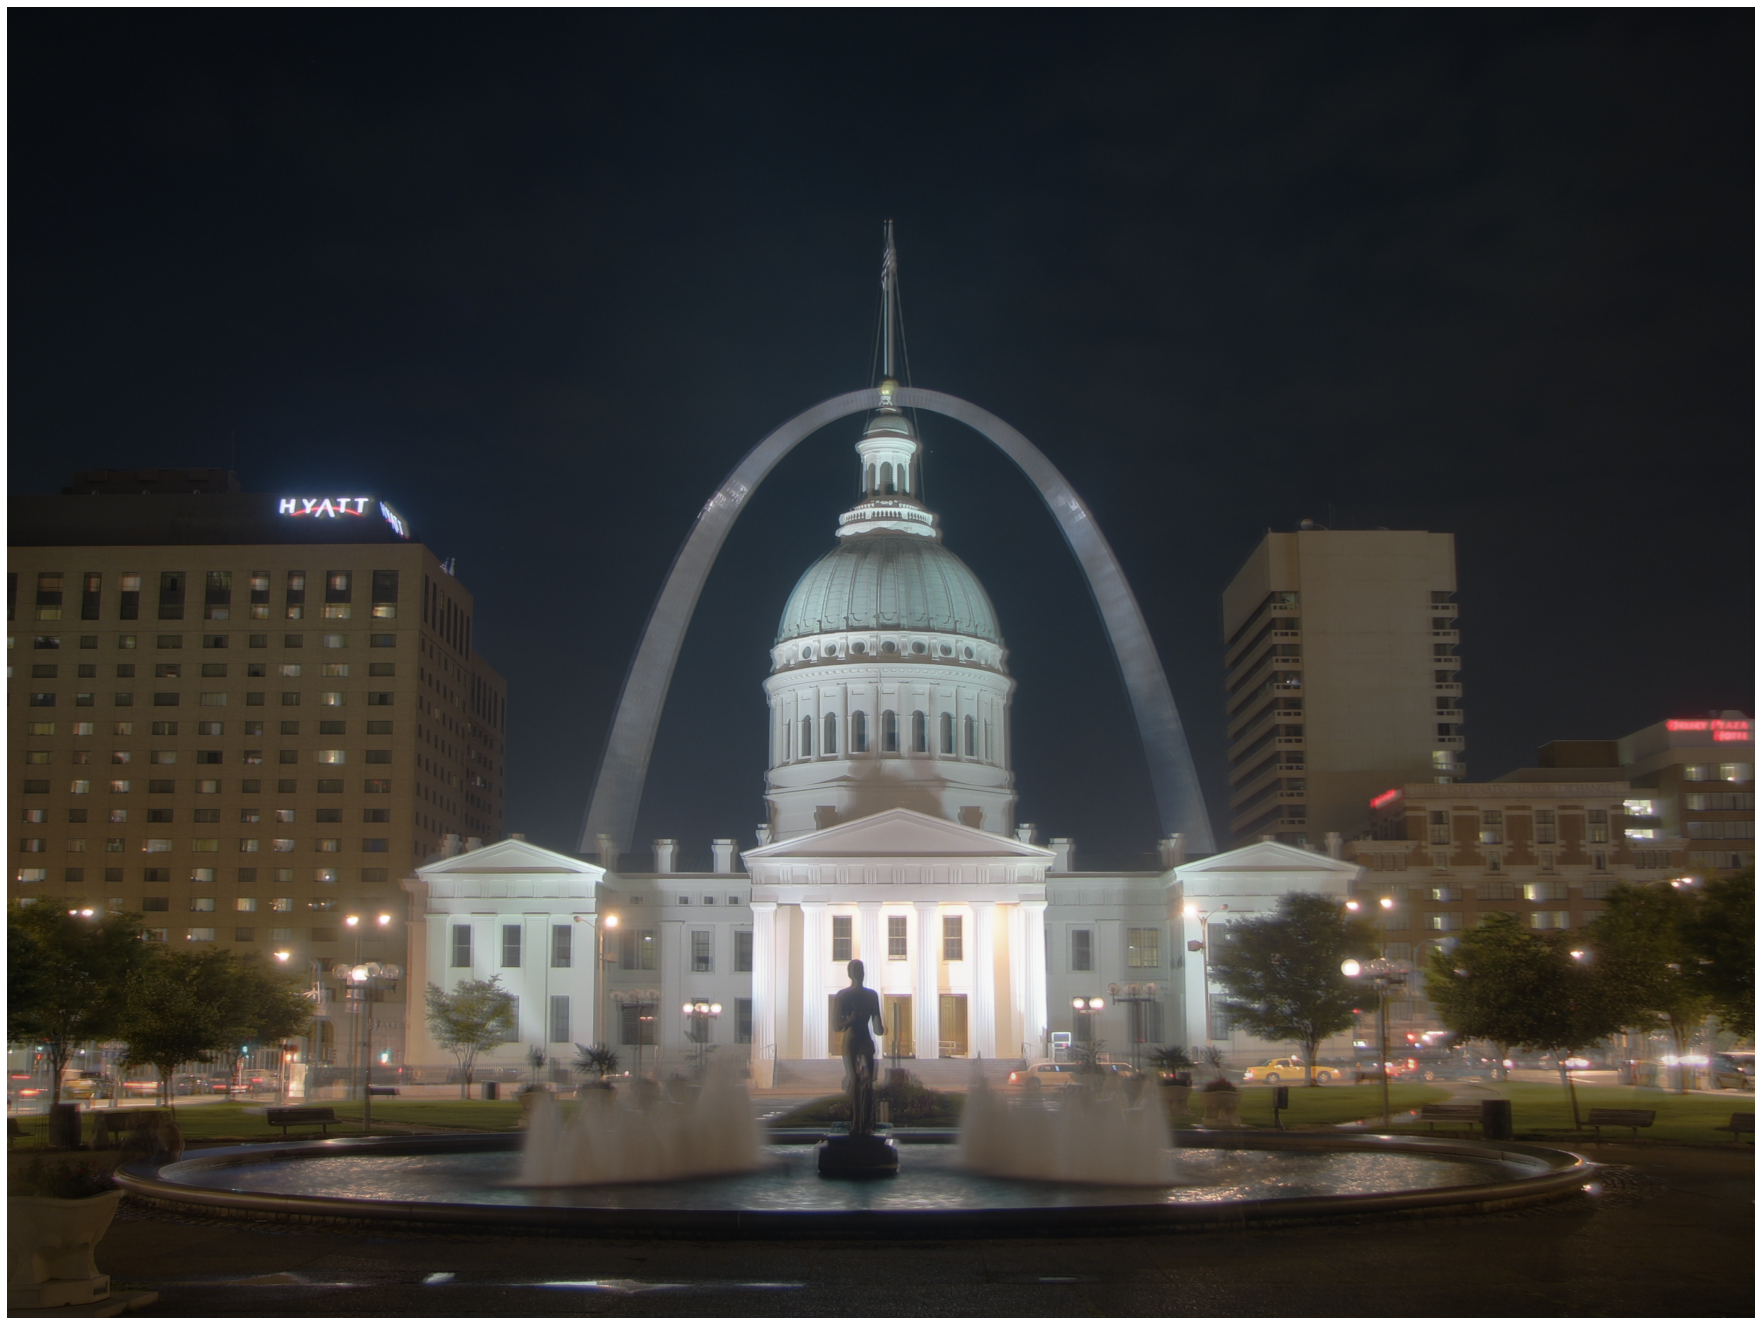

In [4]:
result = image_5
for i in range(len(images) - 1):
    result = (result + images[i]) / 2

f, subplt = plt.subplots(1, figsize=(25, 25))
plt.tight_layout()
plt.imshow(result)
plt.axis('off')

print("Method 1")
for i in range(len(images)):
    print('Image {} vs Original Image:'.format(i + 1))
    compare(np.uint8(images[i] * 255), np.uint8(result * 255))

result_method_1 = result

## Calculate image using wavelete haar transform (Method 2)


Method 2
Image 1:
MSE: 304.72 PSNR: 53.63
Image 2:
MSE: 202.43 PSNR: 57.72
Image 3:
MSE: 326.26 PSNR: 52.95
Image 4:
MSE: 349.80 PSNR: 52.25
Image 5:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


MSE: 345.19 PSNR: 52.38


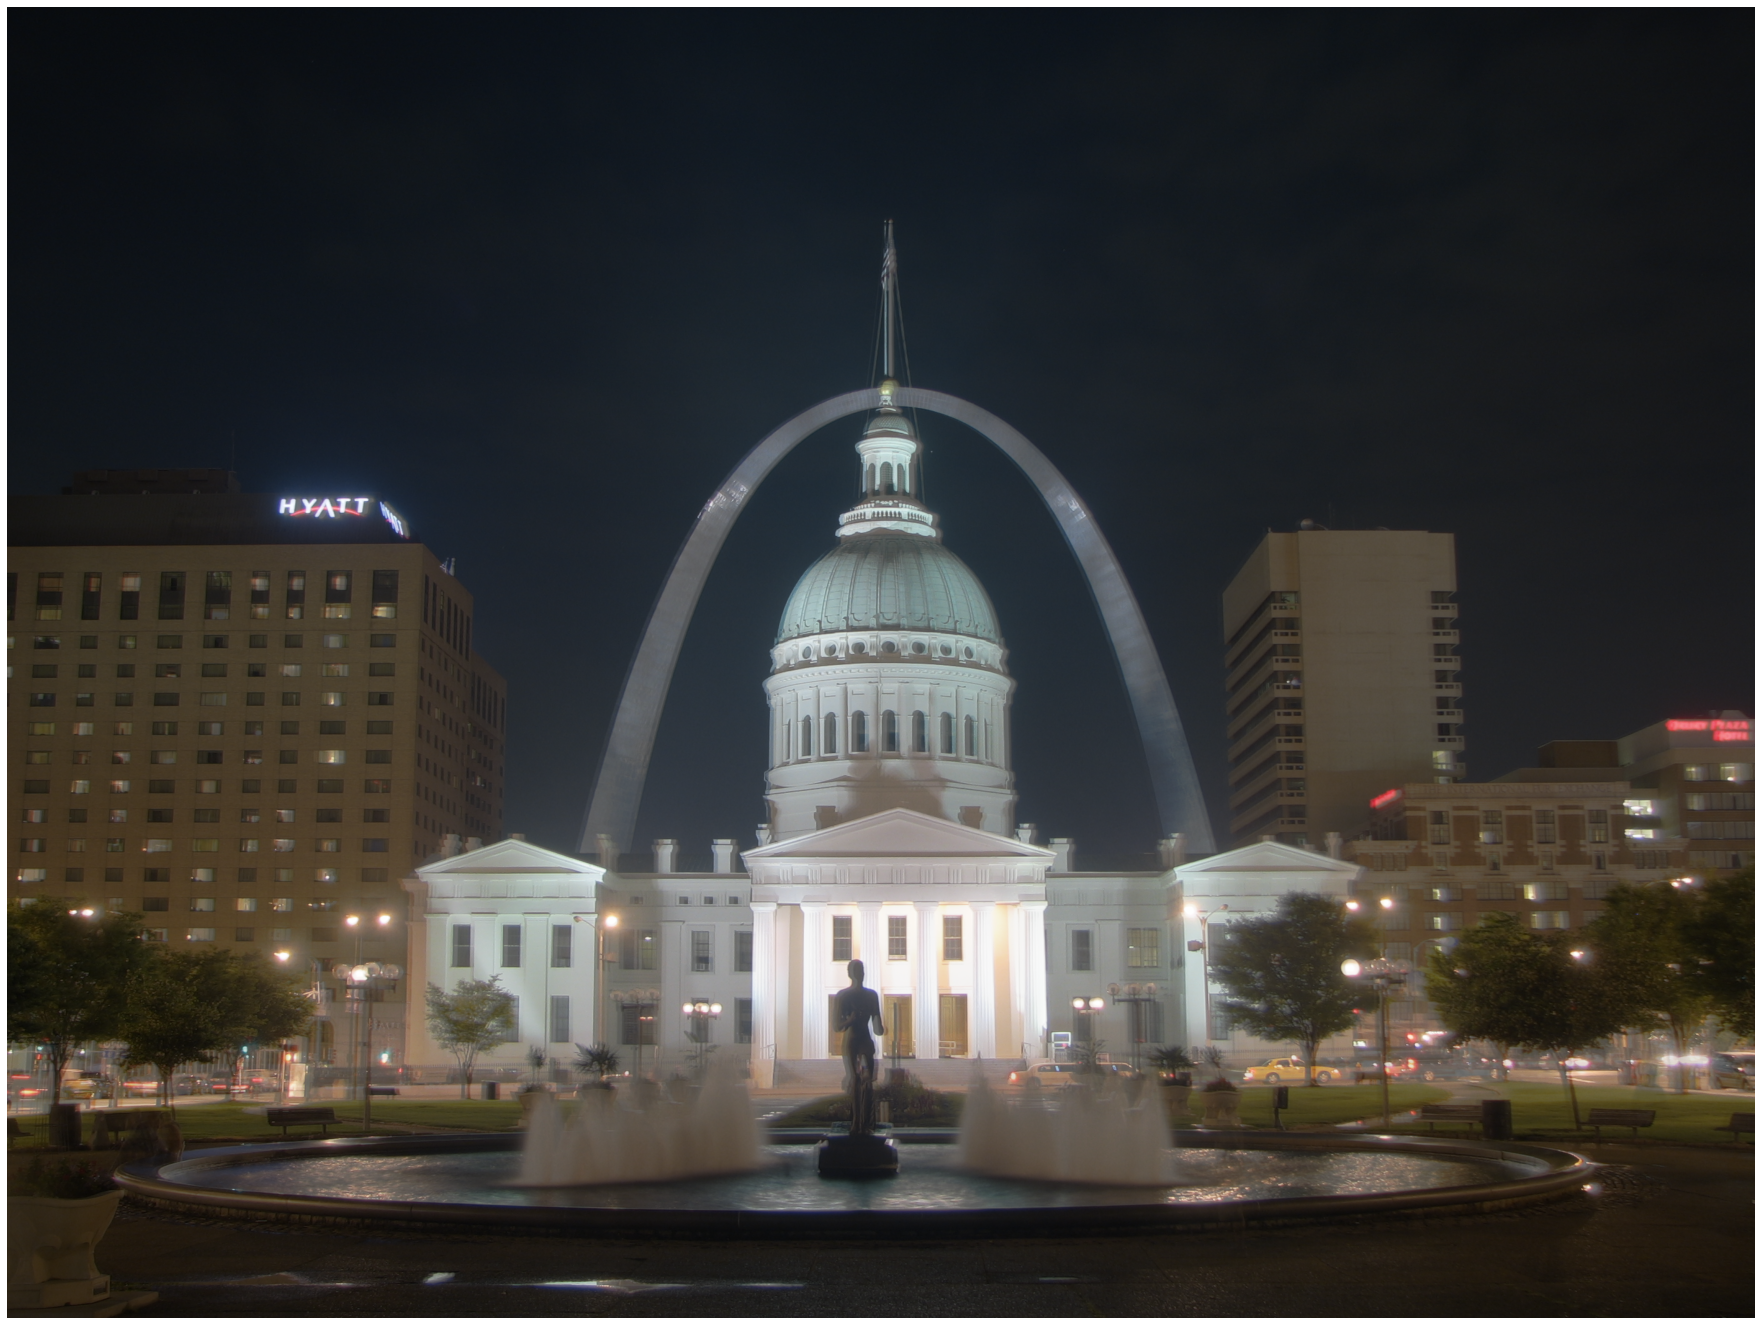

In [5]:
LLs = np.empty((len(images), channels), dtype=object)
LHs = np.empty((len(images), channels), dtype=object)
HLs = np.empty((len(images), channels), dtype=object)
HHs = np.empty((len(images), channels), dtype=object)

## apply wavelete haar transform to images
for i in range(len(images)):
    for c in range(channels):
        LLs[i, c], (LHs[i, c], HLs[i, c],
                    HHs[i, c]) = pywt.dwt2(result[:, :, c], "haar")

LL = np.empty(channels, dtype=object)
LH = np.empty(channels, dtype=object)
HL = np.empty(channels, dtype=object)
HH = np.empty(channels, dtype=object)

## calculate the conditions
for c in range(channels):
    LL[c], (LH[c], HL[c], HH[c]) = np.mean(LLs[:, c], axis=0), (
        reduce(lambda x, y: np.maximum(x, y), LHs[:, c]),
        reduce(lambda x, y: np.maximum(x, y), HLs[:, c]),
        reduce(lambda x, y: np.maximum(x, y), HHs[:, c]),
    )

result = np.zeros(image_1.shape)

## apply reverse wavelete haar transform
for c in range(channels):
    result[:, :, c] = pywt.idwt2((LL[c], (LH[c], HL[c], HH[c])), "haar")

# merge image channels
result = cv2.merge(tuple([result[:, :, c] for c in range(channels)]))

print()
print("Method 2")
for i in range(len(images)):
    print('Image {}:'.format(i + 1))
    compare(np.uint8(images[i] * 255), np.uint8(result * 255))

f, subplt = plt.subplots(1, figsize=(25, 25))
plt.tight_layout()
plt.imshow(result)
plt.axis('off')

result_method_2 = result

## Compare the result of two method

In [6]:
compare(result_method_1, result_method_2)


MSE: 0.00 PSNR: 447.50


As result, according to the results, images are very exact, just a bit different because the PSNR does not have infinite value